In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.stats import laplace
import time

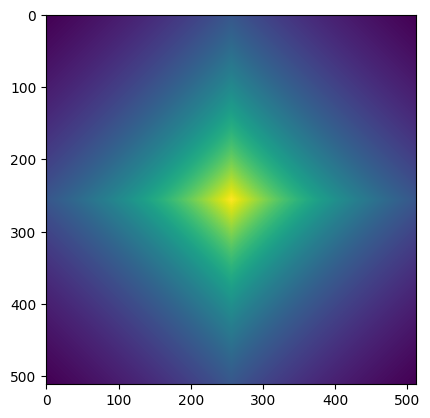

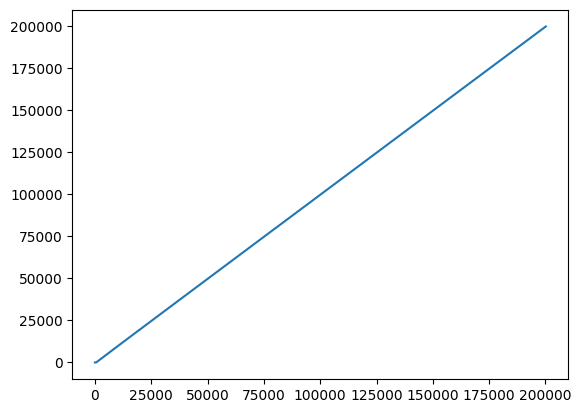

In [11]:
fps = 30
sec_length = 1000
steps = fps * sec_length
cur_frame = 0
interval = 1000 / fps
size = 512
random_move_prob = 0.9
jump_distance = int(1024 * 0.02)
close_dist = 0.05

grid = np.zeros((size, size), dtype=int)
grid[size // 2, size // 2] = 2
stuck_pixels = {(size // 2, size // 2): 1}

loc = size // 2
standard_deviation = size * 0.5
laplace_dist = laplace(loc, standard_deviation)
grid_probs = np.zeros((size, size))

# multivariate normal distribution with mean at center of grid
grid_probs = laplace_dist.pdf(np.arange(size)[:, np.newaxis]) * laplace_dist.pdf(
    np.arange(size)[np.newaxis, :]
)
grid_probs /= grid_probs.sum()
plt.imshow(grid_probs)
plt.show()

# plt.imshow(grid_probs)
# raise Exception("stop here")


class Walker:
    random_move_prob = 0.5
    val = 1
    closest_dist = None
    time_since_last_check = 0

    def __init__(self, random_move_prob, size):
        self.random_move_prob = random_move_prob
        # spawning at edge of grid
        if np.random.random() < 0.25:
            self.x = np.random.randint(0, size)
            self.y = 0
        elif np.random.random() < 0.5:
            self.x = np.random.randint(0, size)
            self.y = size - 1
        elif np.random.random() < 0.75:
            self.x = 0
            self.y = np.random.randint(0, size)
        else:
            self.x = size - 1
            self.y = np.random.randint(0, size)

    def find_distance(self, x, y):
        if self.closest_dist is not None and self.time_since_last_check < 25:
            self.time_since_last_check += 1
            return self.closest_dist

        self.time_since_last_check = 0
        # finding closest distance to any 2
        min_dist = size * 2
        closest = None
        for pixel in stuck_pixels:
            dist = abs(pixel[0] - x) + abs(pixel[1] - y)
            if dist < min_dist:
                min_dist = dist
                closest = pixel

        self.closest_dist = min_dist, closest
        return min_dist, closest

    def move(self):
        if self.val == 2:
            return
        stuck = self.check_collision()
        if stuck:
            return

        grid[self.x, self.y] = 0

        # random move
        if np.random.random() < self.random_move_prob:
            # random_move_time = time.time()
            probs = np.array(
                [
                    grid_probs[max(self.x - 1, 0), self.y],
                    grid_probs[min(self.x + 1, size - 1), self.y],
                    grid_probs[self.x, max(self.y - 1, 0)],
                    grid_probs[self.x, min(self.y + 1, size - 1)],
                ]
            )
            probs = probs / np.sum(probs)

            moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]

            dist, closest = self.find_distance(self.x, self.y)
            if dist > size * close_dist:
                moves = [
                    (-jump_distance, 0),
                    (jump_distance, 0),
                    (0, -jump_distance),
                    (0, jump_distance),
                ]

            move = moves[np.random.choice(4, p=probs)]
            self.x = min(max(self.x + move[0], 0), size - 1)
            self.y = min(max(self.y + move[1], 0), size - 1)
            # random_move_time_end = time.time()
            # print("random move time: ", random_move_time_end - random_move_time)
        # move towards center
        else:
            # center_move_time = time.time()
            dist, closest = self.find_distance(self.x, self.y)
            if dist > size * close_dist:
                moves = [
                    (-jump_distance, 0),
                    (jump_distance, 0),
                    (0, -jump_distance),
                    (0, jump_distance),
                ]
            else:
                moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]

            move_probs = np.array([0.25, 0.25, 0.25, 0.25])
            # give a bias towards the closest pixel of 4
            if closest[0] < self.x:
                move_probs[0] += 1
            elif closest[0] > self.x:
                move_probs[1] += 1
            if closest[1] < self.y:
                move_probs[2] += 1
            elif closest[1] > self.y:
                move_probs[3] += 1

            move_probs = move_probs / np.sum(move_probs)
            move = moves[np.random.choice(4, p=move_probs)]

            self.x = min(max(self.x + move[0], 0), size - 1)
            self.y = min(max(self.y + move[1], 0), size - 1)
            # center_move_time_end = time.time()
            # print("center move time: ", center_move_time_end - center_move_time)

        grid[self.x, self.y] = 1

    def check_collision(self):
        # if any around it are 2, then it becomes 2
        if (
            grid[max(self.x - 1, 0), self.y] == 2
            or grid[min(self.x + 1, size - 1), self.y] == 2
            or grid[self.x, max(self.y - 1, 0)] == 2
            or grid[self.x, min(self.y + 1, size - 1)] == 2
        ):
            self.val = 2
            grid[self.x, self.y] = 2
            stuck_pixels[(self.x, self.y)] = 1
            return True
        else:
            return False


def create_gradient(grid_probs):
    gradient = (grid_probs * 255).astype(np.uint8)
    gradient = cv2.applyColorMap(gradient, cv2.COLORMAP_HOT)
    alpha_channel = np.full((size, size, 1), 255, dtype=np.uint8)
    gradient_image = cv2.merge((gradient, alpha_channel))
    return gradient_image


# creating walkers
walkers = []
stuck = 1
stuck_history = []
stuck_color = (0, 0, 0)
moving_color = (25, 25, 255)
gradient_img = create_gradient(grid_probs)
# simulation loop
# max_frames = 5000
max_stuck = 200000

# using cv2 to create video
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(f"dla-gifs/stuck-{max_stuck}-{500}-1080p.mp4", fourcc, fps, (1080, 1080))
frame_skip = 25

# while stuck < 200 and cur_frame < max_frames:
while stuck < max_stuck:
    if cur_frame % 100 == 0 and len(stuck_history) > 200:
        avg_increase = np.mean(stuck_history)
        print(cur_frame, stuck, end="\r")

    # if there are less than 20 non-stuck walkers, spawn a new one
    if len(walkers) < 500:
        walkers.append(Walker(random_move_prob, size))

    # moving walkers
    walk_time_start = time.time()
    for walker in walkers:
        walker.move()
    walk_time_end = time.time()
    # print("walk time: ", walk_time_end - walk_time_start)

    stuck += len([walker for walker in walkers if walker.val == 2])
    stuck_history.append(stuck)
    # removing stuck walkers
    walkers = [walker for walker in walkers if walker.val != 2]

    if cur_frame % frame_skip == 0:
        print_grid = np.full((size, size, 3), 255, dtype=np.uint8)
        # 2 is white, 1 is red
        print_grid[grid == 2] = stuck_color
        print_grid[grid == 1] = moving_color

        # upscale to 1080x1080
        print_grid = cv2.resize(print_grid, (1080, 1080), interpolation=cv2.INTER_AREA)
        # writing frame to video
        out.write(print_grid)

    cur_frame += 1

out.release()

plt.clf()
plt.plot(stuck_history)
plt.show()

slope:  -1.594223481631431


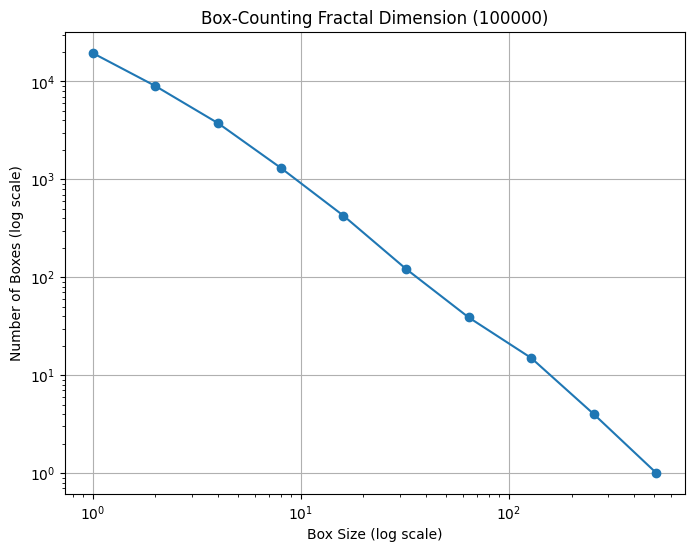

In [9]:
# 1 moving, 2 stuck
def box_counting(grid, box_sizes):
    counts = []
    for box_size in box_sizes:
        # counter for the number of boxes containing part of the structure
        count = 0

        # dividing the grid
        for i in range(0, grid.shape[0], box_size):
            for j in range(0, grid.shape[1], box_size):
                box = grid[i : i + box_size, j : j + box_size]
                # if any of the pixels in the box are part of the structure (2)
                if np.any(box == 2):
                    count += 1

        counts.append(count)

    return counts


min_box_size = 1
max_box_size = min(grid.shape)
box_sizes = [
    2**i for i in range(int(np.log2(min_box_size)), int(np.log2(max_box_size)) + 1)
]

counts = box_counting(grid, box_sizes)

# finding the slope in loglog space
log_box_sizes = np.log(box_sizes)
log_counts = np.log(counts)
slope = np.polyfit(log_box_sizes, log_counts, 1)[0]
print("slope: ", slope)

plt.figure(figsize=(8, 6))
# loglog
plt.loglog(box_sizes, counts, marker="o")
plt.title(f"Box-Counting Fractal Dimension ({max_stuck})")
plt.xlabel("Box Size (log scale)")
plt.ylabel("Number of Boxes (log scale)")
plt.grid(True)
plt.savefig(f"box-counting-{max_stuck}.png")
plt.show()